In [6]:
"""
The script demonstrates a simple example of using ART with Keras. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# replace tqdm imported by any other module with tqdm.notebook
import sys
import tqdm
from tqdm.notebook import tqdm
sys.modules["tqdm"].tqdm = tqdm
sys.modules["tqdm.tqdm"] = tqdm
import ipywidgets as widgets # check if this is installed to make normal tqdm work inside the notebook

import os
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.applications.resnet50 import ResNet50

import numpy as np
import cv2

from art.estimators.classification import KerasClassifier

from art.attacks.evasion import SpatialTransformation
from art.attacks.evasion import FastGradientMethod

from art.defences.trainer import AdversarialTrainer

# from art.utils import load_mnist
from art.utils import load_dataset

#this is what makes the plots transparent in notebooks
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
# sn.set() #this changes the style of all plots, and imshow shows up wrong
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [36]:
# Step 1: Load the MNIST dataset
(x_train_o, y_train), (x_test_o, y_test), min_pixel_value, max_pixel_value = load_dataset('mnist')
x_train_o, y_train = x_train_o[:600], y_train[:600]
x_test_o, y_test = x_test_o[:600], y_test[:600]

new_size = 28*2
x_train = np.zeros((x_train_o.shape[0],new_size,new_size,1), dtype='float64')
x_test = np.zeros((x_test_o.shape[0],new_size,new_size,1), dtype='float64')

for idx, sample in enumerate(x_train_o):
    img = cv2.resize(sample, dsize=(new_size, new_size), interpolation=cv2.INTER_NEAREST)
    x_train[idx] = img[:,:,None]

for idx, sample in enumerate(x_test_o):
    img = cv2.resize(sample, dsize=(new_size, new_size), interpolation=cv2.INTER_NEAREST)
    x_test[idx] = img[:,:,None]    

(600, 56, 56, 1)
(600, 56, 56, 1)


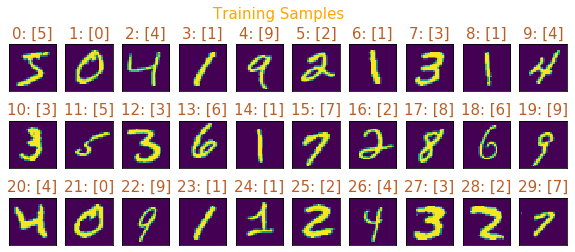

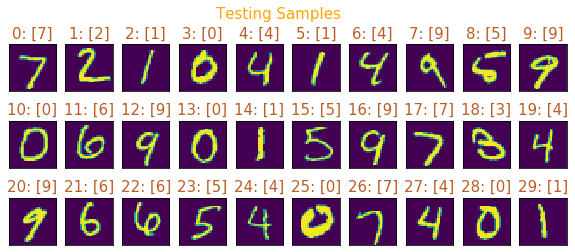

In [38]:
# Step 1.1: Visualize training set and labels
fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i][:,:,0])
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i][:,:,0])
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Testing Samples', fontsize=15, color='orange')

plt.show()

In [50]:
# Step 2: Create the model

model = Sequential()
model.add(ResNet50(input_shape=(new_size,new_size,1),include_top=False, pooling='avg', weights=None))
model.add(Dense(10, activation="softmax"))

model.compile(
    loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001), metrics=["accuracy"]
)

In [51]:
# Step 3: Create the ART classifier

classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

In [52]:
# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=30)

all_acc = {}

Epoch 1/30
9/9 [==============================] - ETA: 1:42 - loss: 3.8122 - acc: 0.046 - ETA: 45s - loss: 3.4314 - acc: 0.140 - ETA: 26s - loss: 3.0276 - acc: 0.19 - ETA: 16s - loss: 3.0261 - acc: 0.21 - ETA: 11s - loss: 2.8186 - acc: 0.26 - ETA: 6s - loss: 2.6123 - acc: 0.3021 - ETA: 4s - loss: 2.4239 - acc: 0.352 - ETA: 1s - loss: 2.2459 - acc: 0.398 - 15s 2s/step - loss: 2.0780 - acc: 0.4392
Epoch 2/30
9/9 [==============================] - ETA: 1s - loss: 1.0482 - acc: 0.750 - ETA: 1s - loss: 0.9849 - acc: 0.742 - ETA: 1s - loss: 0.9766 - acc: 0.739 - ETA: 1s - loss: 0.9160 - acc: 0.757 - ETA: 0s - loss: 0.9328 - acc: 0.743 - ETA: 0s - loss: 0.8340 - acc: 0.773 - ETA: 0s - loss: 0.7434 - acc: 0.796 - ETA: 0s - loss: 0.7035 - acc: 0.800 - 2s 240ms/step - loss: 0.6982 - acc: 0.8073
Epoch 3/30
9/9 [==============================] - ETA: 1s - loss: 0.7659 - acc: 0.812 - ETA: 1s - loss: 0.6479 - acc: 0.820 - ETA: 1s - loss: 0.5313 - acc: 0.843 - ETA: 1s - loss: 0.4894 - acc: 0.851 - ET

9/9 [==============================] - ETA: 1s - loss: 0.0773 - acc: 0.968 - ETA: 1s - loss: 0.0541 - acc: 0.976 - ETA: 1s - loss: 0.0578 - acc: 0.974 - ETA: 1s - loss: 0.0438 - acc: 0.980 - ETA: 0s - loss: 0.0510 - acc: 0.981 - ETA: 0s - loss: 0.0603 - acc: 0.981 - ETA: 0s - loss: 0.0517 - acc: 0.984 - ETA: 0s - loss: 0.0457 - acc: 0.986 - 2s 240ms/step - loss: 0.0428 - acc: 0.9861
Epoch 22/30
9/9 [==============================] - ETA: 1s - loss: 4.5640e-04 - acc: 1.000 - ETA: 1s - loss: 0.0205 - acc: 0.9922    - ETA: 1s - loss: 0.0243 - acc: 0.989 - ETA: 1s - loss: 0.0258 - acc: 0.988 - ETA: 0s - loss: 0.0581 - acc: 0.987 - ETA: 0s - loss: 0.0507 - acc: 0.989 - ETA: 0s - loss: 0.0474 - acc: 0.991 - ETA: 0s - loss: 0.0418 - acc: 0.992 - 2s 240ms/step - loss: 0.0494 - acc: 0.9878
Epoch 23/30
9/9 [==============================] - ETA: 1s - loss: 7.0176e-04 - acc: 1.000 - ETA: 1s - loss: 0.0043 - acc: 1.0000    - ETA: 1s - loss: 0.0457 - acc: 0.984 - ETA: 1s - loss: 0.0390 - acc: 0.984

Accuracy on benign test examples: 83.66666666666667%

[0 1 2 3 4 5 6 7 8 9] 10
[0 1 2 3 4 5 6 7 8 9] 10
Accuracy Score : 0.8366666666666667
Report : 
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        53
           1       0.88      1.00      0.94        73
           2       0.87      0.84      0.86        64
           3       0.89      0.89      0.89        62
           4       0.98      0.75      0.85        67
           5       0.66      0.84      0.74        56
           6       0.92      0.63      0.75        52
           7       0.94      0.84      0.89        57
           8       0.84      0.69      0.76        52
           9       0.96      0.83      0.89        64

    accuracy                           0.84       600
   macro avg       0.86      0.83      0.83       600
weighted avg       0.86      0.84      0.84       600



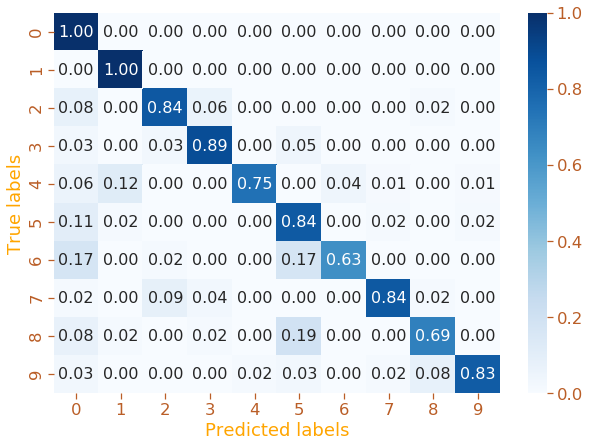

In [53]:
# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
all_acc['nat'] = accuracy * 100

print()

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7))

with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues

plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

{'loss': [2.0779851145214505, 0.6982228689723544, 0.3256712522771623, 0.1844059353073438, 0.08654042954246204, 0.05632994334316916, 0.06119084327171246, 0.05076796333822939, 0.04922895309411817, 0.03226595387483636, 0.09489999682409689, 0.08001816272735596, 0.11094341251171297, 0.0999765088264313, 0.11060354527499941, 0.06420665451959293, 0.10791040147240791, 0.03331133890120933, 0.022631922096479684, 0.0447722481460207, 0.042760139066053346, 0.04935059328434161, 0.06685433837507541, 0.05061066729184757, 0.05535590281296107, 0.03893295833323565, 0.04092547200060734, 0.015044716998090735, 0.052740239965108536, 0.05910218686120869], 'acc': [0.4392361111111111, 0.8072916666666666, 0.9027777777777778, 0.9392361111111112, 0.9704861111111112, 0.9826388888888888, 0.9826388888888888, 0.9878472222222222, 0.9861111111111112, 0.9809027777777778, 0.9774305555555556, 0.9704861111111112, 0.96875, 0.9670138888888888, 0.9670138888888888, 0.9878472222222222, 0.9756944444444444, 0.9826388888888888, 0.99

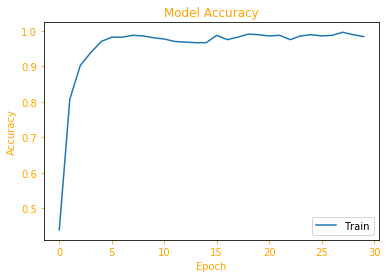

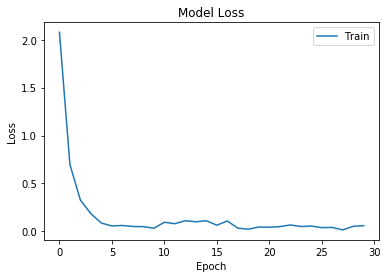

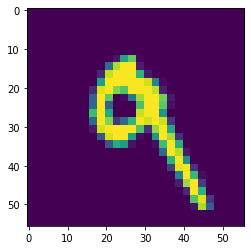

In [54]:
# You can call the underlying model variable at it gives the same results as the wrapped one above
print(classifier._model.history.history)

print("test set stats: {} -> {}".format(classifier._model.metrics_names, classifier._model.evaluate(x_test, y_test)))

# Get all the wrong predictions to see where the classifier messed up
wrong_predictions = np.argwhere((np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) == False)
print(wrong_predictions)
# predictions[wrong_predictions]

# First misclassified sample (index 7, should be a 9, but it says it is a 4)
single_sample = np.expand_dims(x_test[7], axis=0)
print(np.argmax(classifier.predict(single_sample)))
print(classifier._model.predict_classes(single_sample))

plt.figure()
ax = plt.gca()
plt.plot(classifier._model.history.history['acc'])
plt.ylabel('Accuracy', color="orange")
plt.xlabel('Epoch', color="orange")
plt.legend(['Train'], loc='best')
plt.title('Model Accuracy', color="orange")
ax.tick_params(axis='x', colors="orange")
ax.tick_params(axis='y', colors="orange")

plt.figure()
plt.plot(classifier._model.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='best')
plt.title('Model Loss')

plt.figure()
plt.imshow(x_test[7][:,:,0])
plt.show()

In [ ]:
# Step 6: Generate adversarial test examples

# Craft adversarial samples
print("Create adversarial attack")
attack = SpatialTransformation(classifier=classifier, max_translation=10.0, num_translations=1, max_rotation=30.0, num_rotations=1)
# attack = FastGradientMethod(classifier, eps=0.1)
print("Craft attack on training examples")
x_train_adv = attack.generate(x_train)
print("Craft attack test examples")
x_test_adv = attack.generate(x_test)

print(x_train_adv.shape)
print(x_test_adv.shape)

In [ ]:
# Step 6.1: Visualize adversarial samples
fig, axes = plt.subplots(3,10, figsize=(10,4), facecolor='None')
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train_adv[i][:,:,0])
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test_adv[i][:,:,0])
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Test Samples', fontsize=15, color='orange')

plt.show()

In [ ]:
# classifier.save("model.h5", path=".")

In [ ]:
# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples before AT: {}%".format(accuracy * 100))
all_acc['adv_before_AT'] = accuracy * 100

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7), facecolor='None')
with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [ ]:
# Step 8: Create adversarial trainer and perform adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=1.0)
adv_trainer.fit(x_train_adv, y_train, batch_size=64, nb_epochs=3)

In [ ]:
# Step 9: Evaluate new robustly trained classifier
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples after AT: {}%".format(accuracy * 100))
all_acc['adv_after_AT'] = accuracy * 100

print(all_acc)

In [ ]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))
# %matplotlib inline
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))

plt.figure(figsize=(10,7), facecolor='None')
# print(plt.style.available)
# plt.style.use('default')
with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    hm = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()
# dir(hm)
[(param, value) for param, value in plt.rcParams.items() if 'color' in param]